# A/B Testing - Homepage Experiment

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

## 1. Experiment 1
First change là Udacity muốn thay đổi homepage design. Metric là **Click-through rate (CTR)**, đc defined là number of clicks chia cho number of views.
**CTR: # clicks by unique users / # views by unique users**

Hypotheses là:
$$
H_0:CTR_{new} \le CTR_{old}; \quad H_1: CTR_{new} > CTR_{old}
$$

Alternative hypothesis là điều ta mong muốn, và null hypothesis là điều ta giả định là đúng trước khi analyze data, nghĩa là new homepage design CTR ko cao hơn CTR của old homepage design. Có thể rearrange hypotheses thành:
$$
H_0:CTR_{new} - CTR_{old} \le 0; \quad H_1: CTR_{new} - CTR_{old} > 0
$$

In [12]:
df = pd.read_csv('homepage_actions.csv')
df.head()

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view


### 1.1 Match the following characteristics of this dataset

In [13]:
# Total number of actions
df.action.count()

8188

In [14]:
# Number of unique users
df.id.nunique()

6328

In [15]:
# Size of control group and experiment group
control_df = df.query("group=='control'")
experiment_df = df.query("group=='experiment'")

In [16]:
print(len(control_df), len(experiment_df))

4264 3924


### 1.2. How long was the experiment run for?

In [17]:
min_timestamp = pd.to_datetime(df.timestamp.min())
max_timestamp = pd.to_datetime(df.timestamp.max())
pd.Timedelta(max_timestamp-min_timestamp)

Timedelta('115 days 16:41:40.789831')

### 1.3. What action types are recorded in this dataset?

In [18]:
df.action.unique()

array(['view', 'click'], dtype=object)

### 1.4. CTR

In [19]:
df.query('action == "click"').id.nunique() / df.query('action == "view"').id.nunique()

0.2939317319848293

## 2. Experiment
Second change là Udacity muốn thay đổi course overview page có more career-focused description. Các metrics là:
1. __Enrollment Rate__: Click-through rate for the Enroll button on the course overview page
2. __Average Reading Duration__: Average number of seconds spent on the course overview page
3. __Average Classroom Time__: Average number of days spent in the classroom for students enrolled in the course
4. __Completion Rate__: Course completion rate for students enrolled in the course

Các bước thực hiện A/B test cho mỗi metric:
1. Tính observed difference between the metric của control và experiment groups.
2. Mô phỏng sampling distribution for the difference in means.
3. Dùng sampling distribution để mô phỏng distribution under null hypothesis bằng cách tạo một normal distribution centered at 0 with same spread and size.
4. Tính p-value là proportion of values in null distribution greater than observed difference.
5. Dùng p-value để xđ statistical significance of observed difference.

### 2.1. Metric: Enrollmennt Rate

In [20]:
df = pd.read_csv('course_page_actions.csv')
df.head()

,timestamp,id,group,action,duration
0,2016-09-24 17:14:52.012145,261869,experiment,view,130.545004
1,2016-09-24 18:45:09.645857,226546,experiment,view,159.862440
2,2016-09-24 19:16:21.002533,286353,experiment,view,79.349315
3,2016-09-24 19:43:06.927785,842279,experiment,view,55.536126
4,2016-09-24 21:08:22.790333,781883,experiment,view,204.322437


In [21]:
# Get dataframe with all records from control group
control_df = df.query('group == "control"')

# Compute click through rate for control group
control_ctr = control_df.query('action == "enroll"').id.nunique() / control_df.query('action == "view"').id.nunique()

# Display click through rate
control_ctr

0.2364438839848676

In [22]:
# Get dataframe with all records from experiment group
experiment_df = df.query('group == "experiment"')

# Compute click through rate for experiment group
experiment_ctr = experiment_df.query('action == "enroll"').id.nunique() / experiment_df.query('action == "view"').id.nunique()

# Display click through rate
experiment_ctr

0.2668693009118541

In [23]:
# Compute the observed difference in click through rates
obs_diff = experiment_ctr - control_ctr

# Display observed difference
obs_diff

0.030425416926986526

In [24]:
# Create a sampling distribution of the difference in proportions
# with bootstrapping
diffs = []
size = df.shape[0]
for _ in range(10000):
    b_samp = df.sample(size, replace=True)
    control_df = b_samp.query('group == "control"')
    experiment_df = b_samp.query('group == "experiment"')
    control_ctr = control_df.query('action == "enroll"').id.nunique() / control_df.query('action == "view"').id.nunique()
    experiment_ctr = experiment_df.query('action == "enroll"').id.nunique() / experiment_df.query('action == "view"').id.nunique()
    diffs.append(experiment_ctr - control_ctr)

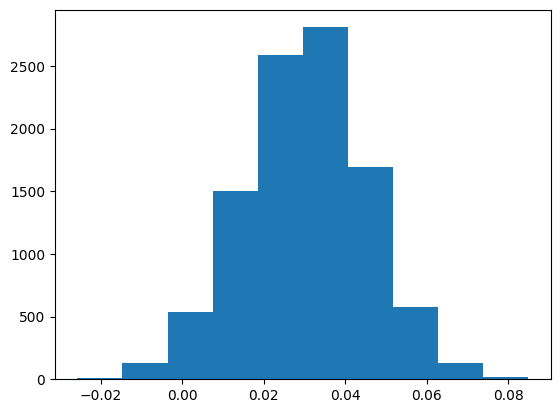

In [25]:
diffs = np.array(diffs)
plt.hist(diffs);

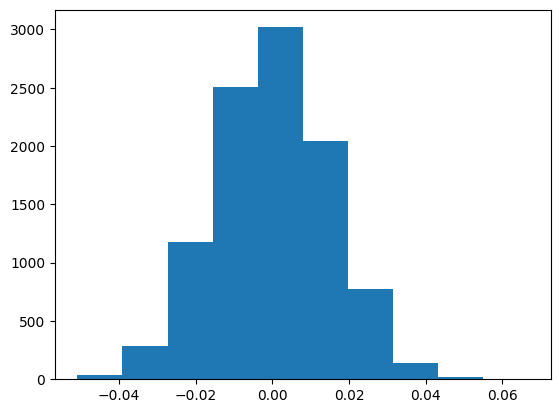

In [26]:
# Simulate distribution under the null hypothesis
null_vals = np.random.normal(0, diffs.std(), diffs.size)

# Plot the null distribution
plt.hist(null_vals);

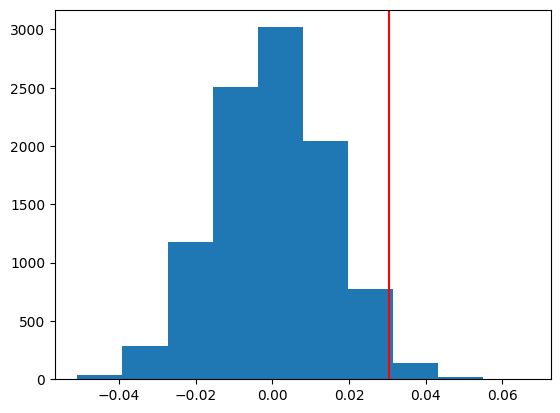

In [27]:
# Plot observed statistic with the null distibution
plt.hist(null_vals);
plt.axvline(obs_diff, c='red')

In [28]:
# Compute p-value
(null_vals > obs_diff).mean()

0.0188

### 2.2. Metric: Average Reading Duration

In [29]:
# get only the views
views = df.query('action == "view"')

# Group by id and group with the duration mean.
reading_times = views.groupby(['id','group'])['duration'].mean()

#reset index to keep this as a dataframe
reading_times = reading_times.reset_index()
reading_times.head()

,id,group,duration
0,183260,control,107.331484
1,183615,experiment,24.627594
2,184277,experiment,193.212489
3,184360,experiment,226.586283
4,184589,experiment,12.052097


In [30]:
#get means for control/experiment
control_mean = df.query('group == "control"')['duration'].mean()
experiment_mean = df.query('group == "experiment"')['duration'].mean()
control_mean, experiment_mean

(115.40710650582048, 130.93220512539497)

In [31]:
obs_diff = experiment_mean - control_mean
obs_diff

15.525098619574493

In [32]:
#bootstrap sample
diffs = []
for _ in range(10000):
    b_samp = df.sample(df.shape[0], replace=True)
    control_mean = b_samp.query('group == "control"')['duration'].mean()
    experiment_mean = b_samp.query('group == "experiment"')['duration'].mean()
    diffs.append(experiment_mean - control_mean)

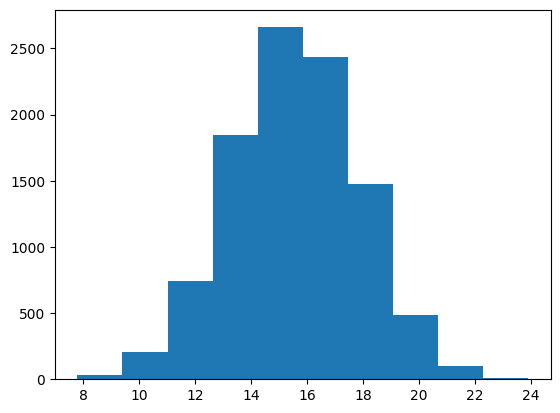

In [33]:
diffs = np.array(diffs)
plt.hist(diffs);

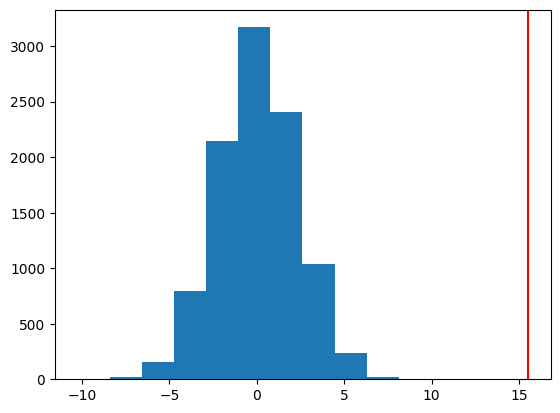

In [34]:
null_vals = np.random.normal(0.,diffs.std(),diffs.size)
plt.hist(null_vals);
plt.axvline(x=obs_diff,color='red');

In [35]:
# Compute p-value
(null_vals > obs_diff).mean()

0.0

### 2.3. Metric: Average Classroom Time

In [36]:
df = pd.read_csv('classroom_actions.csv')
df.head()

,timestamp,id,group,total_days,completed
0,2015-08-10 17:06:01.032740,610019,experiment,97,True
1,2015-08-10 17:15:28.950975,690224,control,75,False
2,2015-08-10 17:34:40.920384,564994,experiment,128,True
3,2015-08-10 17:50:39.847374,849588,experiment,66,False
4,2015-08-10 19:10:40.650599,849826,experiment,34,False


In [37]:
# get the average classroom time for control group
control_mean = df.query('group == "control"').total_days.mean()

# get the average classroom time for experiment group
experiment_mean = df.query('group == "experiment"').total_days.mean()

# display average classroom time for each group
control_mean, experiment_mean

(73.36899038461539, 74.6715935334873)

In [38]:
# compute observed difference in classroom time
obs_diff = experiment_mean - control_mean

# display observed difference
obs_diff

1.3026031488719099

In [39]:
# create sampling distribution of difference in average classroom times
# with boostrapping
diffs = []
size = df.shape[0]
for _ in range(10000):
    b_samp = df.sample(size, replace=True)
    control_mean = b_samp.query('group == "control"').total_days.mean()
    experiment_mean = b_samp.query('group == "experiment"').total_days.mean()
    diffs.append(experiment_mean - control_mean)

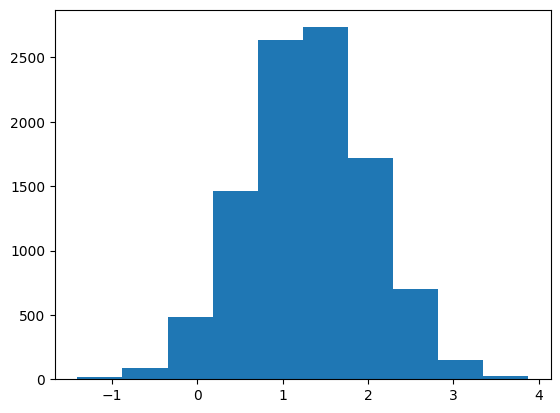

In [40]:
diffs = np.array(diffs)
plt.hist(diffs);

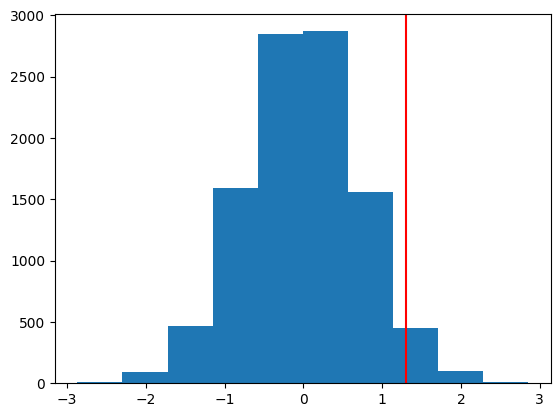

In [41]:
# simulate distribution under the null hypothesis
null_vals = np.random.normal(0, diffs.std(), diffs.size)
plt.hist(null_vals);
plt.axvline(obs_diff, c='red')

In [42]:
# compute p value
(null_vals > obs_diff).mean()

0.0387

### 2.4. Metric: Completion Rate

In [43]:
# Create dataframe with all control records
control_df = df.query('group == "control"')

# Compute completion rate
control_ctr = control_df['completed'].mean()

# Display control complete rate
control_ctr

0.3719951923076923

In [44]:
# Create dataframe with all experiment records
experiment_df = df.query('group == "experiment"')

# Compute completion rate
experiment_ctr = experiment_df['completed'].mean()

# Display experiment complete rate
experiment_ctr

0.3935334872979215

In [45]:
# Compute observed difference in completion rates
obs_diff = experiment_ctr - control_ctr

# Display observed difference in completion rates
obs_diff

0.02153829499022919

In [46]:
# Create sampling distribution for difference in completion rates with boostrapping
diffs = []
size = df.shape[0]
for _ in range(10000):
    b_samp = df.sample(size, replace=True)
    control_df = b_samp.query('group == "control"')
    experiment_df = b_samp.query('group == "experiment"')
    control_ctr = control_df['completed'].mean()
    experiment_ctr = experiment_df['completed'].mean()
    diffs.append(experiment_ctr - control_ctr)

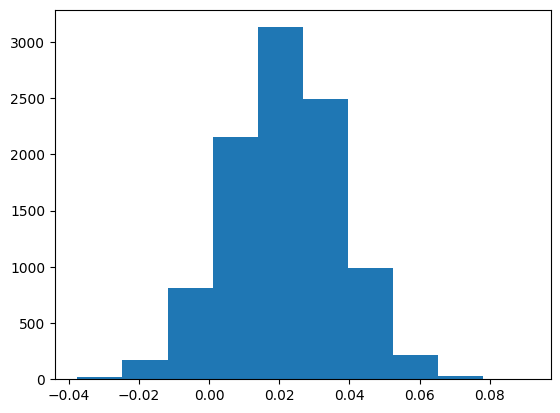

In [51]:
diffs = np.array(diffs)
plt.hist(diffs);

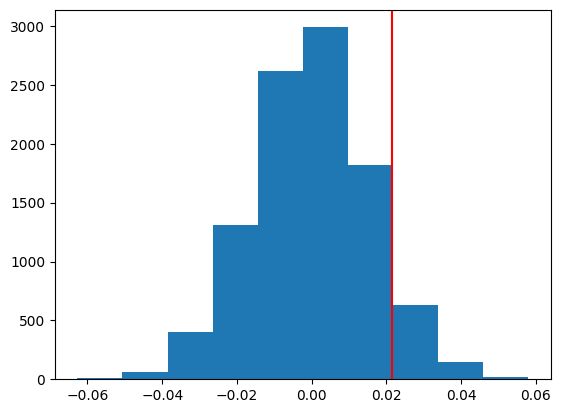

In [50]:
# create distribution under the null hypothesis
null_vals = np.random.normal(0, diffs.std(), diffs.size)
plt.hist(null_vals);
plt.axvline(obs_diff, c='red');

In [52]:
# compute p value
(null_vals > obs_diff).mean()

0.082